# Setup

In [1]:
!pip install geemap -q

In [1]:
import ee
ee.Authenticate()
ee.Initialize()

Enter verification code:  4/1AY0e-g6UcbS1uvxBHGBSByOSceODZwtB05ZT6g_oGZXAesGaMIZ7Dg_QMhE



Successfully saved authorization token.


# Prepare feature images (simplified)

In [5]:
start_date = ee.Date.fromYMD(2016,1,1)
end_date = ee.Date.fromYMD(2020,12,31)

# Define study region
study_region = ee.Geometry.Polygon([
  [33,-20], [33,-19], [34,-19], [34,-20], [33,-20]]);

s2 = ee.ImageCollection("COPERNICUS/S2_SR")\
  .filterBounds(study_region)\
  .filterMetadata('GRANULE_ID','contains','36KWD');

# Mask clouds
def maskClouds(im):
  
  im = im.updateMask((im.select('SCL').gte(4))\
                       .bitwise_and(im.select('SCL').lte(6)))
    
  return im


# Add spectral indices
def addVIs(im):
  
  # NDVI
  ndvi = im.normalizedDifference(['B8','B4']).rename('NDVI')
  im = im.addBands(ndvi);
  
  # EVI
  evi = im.expression(
    '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
      'NIR': im.select('B8'),
      'RED': im.select('B4'),
      'BLUE': im.select('B2')}).rename('EVI')
  im = im.addBands(evi)
  
  # GEMI
  n = im.expression(
    '(2 * (NIR ** 2 - RED ** 2) + 1.5 * NIR + 0.5 * RED) / (NIR + RED + 0.5)', {
      'NIR': im.select('B8'),
      'RED': im.select('B4')})
  gemi = im.expression(
    '(N * (1 - 0.25 * N)) - ((RED - 0.125) / (1 - RED))', {
      'N': n,
      'RED': im.select('B4')}).rename('GEMI')
  im = im.addBands(gemi)
  
  # NDMI
  ndmi = im.normalizedDifference(['B8','B11']).rename('NDMI')
  im = im.addBands(ndmi)
  
  # SAVI
  savi = im.expression(
    '(1 + 0.5) * ((NIR - RED) / (NIR + RED + 0.5))', {
      'RED': im.select('B4'),
      'NIR': im.select('B8')
    }).rename('SAVI')
  im = im.addBands(savi)
  
  # RENDVI
  rendvi = im.normalizedDifference(['B6','B5']).rename('RENDVI')
  i = im.addBands(rendvi)
  
  # MSI
  msi = (im.select('B11').divide(im.select('B8'))).rename('MSI')
  im = im.addBands(msi)
  
  # NBR
  nbr = im.normalizedDifference(['B8','B12']).rename('NBR')
  im = im.addBands(nbr)
  
  # MIRBI
  mirbi = im.expression(
    '(10 * SWIR2) - (9.8 * SWIR2) + 2', {
      'SWIR1': im.select('B11'),
      'SWIR2': im.select('B12')}).rename('MIRBI')
  im = im.addBands(mirbi)
  
  # Replace infinite or undefined values
  # TODO
  
  return im


# Compute spatial percentile of index (spatial context)
def percentileImage(image, percentile = 95, kernel = 11):
  
  im_percentile = image.reduceNeighborhood(**{
    'reducer': ee.Reducer.percentile([percentile]),
    'kernel': ee.Kernel.circle(kernel),
  })
  
  return im_percentile.rename('PERC')

# Compute spatial context
def addSpatialContext(im):

  perc_60 = percentileImage(im.select('NDVI'), 95, 3).rename('PERC_60')
  perc_600 = percentileImage(im.select('NDVI'), 95, 30).rename('PERC_600')
  perc_2400 = percentileImage(im.select('NDVI'), 95, 120).rename('PERC_2400')
  
  im = im.addBands(perc_60).addBands(perc_600).addBands(perc_2400)
  
  return im


# Image texture (stdev convolution)
def stdConvolution(im, kernel = 3):
    
  texture = im.reduceNeighborhood(**{
      'reducer': ee.Reducer.stdDev(),
      'kernel': ee.Kernel.circle(kernel)
    })
  
  return texture


# Image texture (mean convolution)
def meanConvolution(im, kernel = 3):
  
  texture = im.reduceNeighborhood(**{\
    'reducer': ee.Reducer.mean(),
    'kernel': ee.Kernel.circle(kernel)
    })
  
  return texture

def addTexture(im):
  
  std_3 = stdConvolution(im.select('NDVI'), kernel = 3).rename('STD_3')
  std_9 = stdConvolution(im.select('NDVI'), kernel = 9).rename('STD_9')
  
  im = im.addBands(std_3).addBands(std_9)

  return im


def addCoefVar(im):
  
  coef_var = im.select('STD_3')\
    .divide(meanConvolution(im.select('NDVI'), kernel = 3))\
    .rename('COEF_VAR')
  
  im = im.addBands(coef_var)
  
  return im

def addTimeOfYear(im):
 
  #Day of year
  doy = im.date().getRelative('day', 'year').toFloat()
  
  #Position in year
  poy = ee.Image(doy).divide(365.25)
  
  #Spring/Autumn
  im = im.addBands(poy.sin().rename('TIME_SIN'))
  
  #Winter/Summer
  im = im.addBands(poy.cos().rename('TIME_COS'))
  
  return im


s2 = s2.map(maskClouds)
s2 = s2.map(addVIs)
s2 = s2.map(addSpatialContext)
s2 = s2.map(addTexture)
s2 = s2.map(addCoefVar)
s2 = s2.map(addTimeOfYear)

#print(s2.first());

#Ma.addLayer(s2.first().select('MIRBI'))

# Collect training data

In [4]:
#ipyleaflet doesn't seem compatible with SEPAL, fall back on folium
import geemap.eefolium as geemap 

s2_display = ee.ImageCollection("COPERNICUS/S2")

def addNDVI(im):
    return im.addBands(im.normalizedDifference(['B8','B4']).rename('NDVI'))
s2_display = s2_display.map(addNDVI)

s2_t1 = s2_display.filterDate('2015-12-01','2016-06-01')
s2_t2 = s2_display.filterDate('2019-12-01','2020-06-01')

# Training polygons
fc = ee.FeatureCollection('users/sambowers/deforest_sample_training_data');

Map = geemap.Map()
Map.centerObject(study_region, zoom=9)
Map.setOptions('SATELLITE')
vis_params = {'min':0, 'max':2000, 'bands':['B4','B3','B2']}
Map.addLayer(s2_t1.qualityMosaic('NDVI').clip(study_region), vis_params, 'S2_t1')
Map.addLayer(s2_t2.qualityMosaic('NDVI').clip(study_region), vis_params, 'S2_t2')

Map.addLayer(fc.filter(ee.Filter.eq('landcover', 0)),{'color':'darkorange'}, 'Stable nonforest')
Map.addLayer(fc.filter(ee.Filter.eq('landcover', 1)),{'color':'skyblue'}, 'Stable forest')

Map.addLayerControl()
Map

# Export training data

In [22]:

fc = ee.FeatureCollection('users/sambowers/deforest_sample_training_data');

def addClassBand(im):
  im = im.addBands(
    fc.reduceToImage(**{
      'properties': ['landcover'],
      'reducer': ee.Reducer.first()})\
      .add(1).toInt().rename('landcover'))

  return im

s2_sample = ee.ImageCollection(s2.randomColumn('random', 12).sort('random').limit(100));

input_bands = ['B2','B3','B4','B5','B6','B7','B8','B11','B12','NDVI','EVI','SAVI','NBR','MIRBI','STD_3','STD_9','PERC_60','COEF_VAR']

s2_sample = s2_sample.select(input_bands);

s2_sample = s2_sample.map(addClassBand)


# Extract data from subset of images
def extractTrainingPoints(im):
  
  # Get samples from image
  training = im.stratifiedSample(**{
    'numPoints': 1000, 
    'classBand': "landcover", 
    'region': study_region,
    'scale': 20
  })
  
  return training

# Map and flatten to reduce to a collection of features
training_data = ee.FeatureCollection(s2_sample.map(extractTrainingPoints)).flatten()

# Add an arbitrary geometry to allow for export
def addGeometry(feat):
  return feat.setGeometry(s2.geometry().centroid())

training_data = training_data.map(addGeometry)

# Export an ee.FeatureCollection as an Earth Engine asset.
task = ee.batch.Export.table.toAsset(**{
  'collection': training_data,
  'description':'deforest_training_data',
  'assetId':'users/sambowers/deforest_training_data',
});

task.start()

# Train a classifier

In [2]:
fc = ee.FeatureCollection('users/sambowers/deforest_training_data');

fc = fc.remap([1,2],[0,1],'landcover')

classifier = ee.Classifier.smileRandomForest(numberOfTrees=128, minLeafPopulation=4, seed=0)

input_properties = ['B2','B3','B4','B5','B6','B7','B8','B11','B12','NDVI','EVI','SAVI','NBR','MIRBI','STD_3','STD_9','PERC_60','COEF_VAR']

classifier = classifier.train(**{'features': fc,
                                 'classProperty': 'landcover',
                                 'inputProperties': input_properties})

classifier_details = classifier.explain().getInfo()

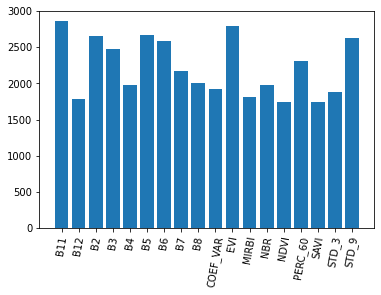

In [3]:
import matplotlib.pyplot as plt

plt.bar(classifier_details['importance'].keys(), classifier_details['importance'].values())
plt.xticks(rotation=80)
plt.show()

In [7]:
import geemap.eefolium as geemap 

#print(t.getInfo())
example_im = ee.Image(s2.sort('CLOUDY_PIXEL_PERCENTAGE').first());

t = example_im.classify(classifier.setOutputMode('PROBABILITY'))

Map = geemap.Map()
Map.centerObject(study_region, zoom=9)
Map.setOptions('SATELLITE')
vis_params = {'min':0, 'max':1, 'palette':['white','lightgreen','darkgreen','black']}
Map.addLayer(t, vis_params, 'p(Forest)')

Map.addLayerControl()
Map

# Apply classifier to each image

In [11]:
def classifyImage(im):
  classified = ee.Image(im.classify(classifier.setOutputMode('PROBABILITY')).rename('forest_prob')).byte()
  classified = classified.unmask(255);
  classified = classified.copyProperties(im, ['system:time_start'])
  return classified

s2_pForest = s2.map(classifyImage)

def addOutputName(im):
  
  #Format: 'NAME_S2_TILE_DATE_TIME.tif'
  
  output_name = ee.String('DEFOREST').cat('_')\
    .cat(ee.String('S2')).cat('_')\
    .cat(ee.String('36KWD')).cat('_')\
    .cat(im.date().format('YYYYMMdd')).cat('_')\
    .cat(ee.String('000000'))
  
  im = im.set('output_name', output_name)
  
  return im

s2_pForest = s2_pForest.map(addOutputName)

t = s2_pForest.first().getInfo()



In [10]:
print(t)

{'type': 'Image', 'bands': [{'id': 'forest_prob', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [10980, 10980], 'crs': 'EPSG:32736', 'crs_transform': [10, 0, 499980, 0, -10, 7900000]}], 'properties': {'system:time_start': 1544861121000, 'output_name': 'DEFOREST_S2_36KWD_20181215_000000', 'system:footprint': {'type': 'LinearRing', 'coordinates': [[32.999796849916855, -19.98471508803333], [32.99980879365058, -19.984715794333667], [34.04911137989149, -19.981612495586443], [34.04915523118319, -19.981575639280823], [34.04920367153898, -19.98154428522826], [34.0492065609629, -19.98152947318649], [34.0459726433017, -19.485566647304925], [34.04283600816862, -18.989583746872544], [34.042797083196355, -18.98954254471353], [34.04276393746451, -18.98949698133489], [34.04274829947401, -18.989494228315916], [32.999809996616484, -18.992431774743256], [32.99976617427762, -18.9924683436307], [32.99971779783015, -18.992499447485358], [32.99971479041257, -18.99251423315351], [32